In [34]:
import json
import pprint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

from scipy.interpolate import make_interp_spline

In [20]:
gamerName = input("소환사명을 입력하세요.")
gamerName

'미니언142'

In [21]:
userId = None
with open(f"../data/{gamerName}_userId.txt", "r") as userId_file:
  userId = int(userId_file.read().strip())
userId

203449844

In [22]:
def call_log(gamerName):
  with open(f"../data/{gamerName}_gameInfo.json", "r") as json_log:
    gameInfo = json.load(json_log)
  with open(f"../data/{gamerName}_timeline.json", "r") as json_log:
    timeline = json.load(json_log)
  return gameInfo, timeline

gameInfo, timeline = call_log(gamerName)

In [23]:
def find_me(userId, gameIndex):
  for player in gameInfo[gameIndex]['participantIdentities']:
    if player['player']['accountId'] == userId:
      return player['participantId']

In [24]:
win_rate = []
for gameIndex in range(len(gameInfo)):
  for player in gameInfo[gameIndex]['participants']:
    if player['participantId'] == find_me(userId, gameIndex):
      win_rate.append(player['stats']['win'])

In [15]:
# 승률 구하는 부분
sum(win_rate) / len(win_rate) * 100

56.09756097560976

# 매치 승률 구하기

## 시간대별 게임 수 시각화

In [9]:
gameDay = []
for i in range(len(gameInfo)):
  gameDay.append(int(datetime.datetime.fromtimestamp(gameInfo[i]['gameCreation'] // 1000).strftime("%H")))

In [10]:
# Prepare Data
gameTime = pd.Series(gameDay)
gameTime = gameTime.value_counts()
for i in range(24):
  if i not in gameTime.index:
    gameTime[i] = 0

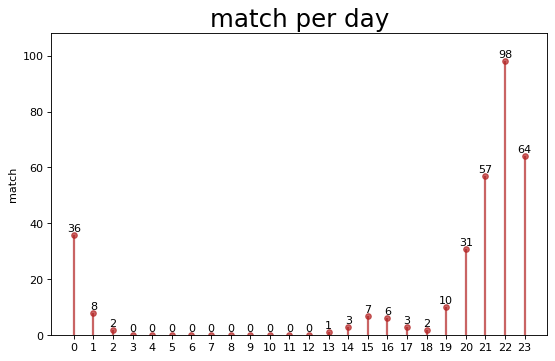

In [11]:
# Draw plot
fig, ax = plt.subplots(figsize=(8,5), dpi= 80)
ax.vlines(x=gameTime.index, ymin=0, ymax=gameTime.values, color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=gameTime.index, y=gameTime.values, s=25, color='firebrick', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('match per day', fontdict={'size':22})
ax.set_ylabel('match')
ax.set_xticks(gameTime.index)
ax.set_xticklabels(gameTime.index, rotation=0, fontdict={'horizontalalignment': 'center', 'size':10})
ax.set_ylim(0, gameTime.values.max() + 10)

# Annotate
for index, value in gameTime.iteritems():
  ax.text(index, value+.5, s=round(value, 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=10)

plt.show()

## 매치승률 구하기

In [12]:
WinPerDayDf = pd.DataFrame()
for i in range(len(gameInfo)):
  WinPerDay = pd.Series()
  WinPerDay['datetime'], WinPerDay['Hour'] = list(map(int, datetime.datetime.fromtimestamp(gameInfo[i]['gameCreation'] // 1000).strftime("%Y%m%d,%H").split(',')))
  # print(WinPerDay['datetime'], WinPerDay['Hour'])
  for player in gameInfo[i]['participants']:
    if player['participantId'] == find_me(userId, i):
      WinPerDay['win'] = player['stats']['win']
      break
  WinPerDayDf = WinPerDayDf.append(WinPerDay, ignore_index=True)

<ipython-input-12-22bee9cbddcf>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  WinPerDay = pd.Series()


In [13]:
WinPerDayDf['Hour'] = WinPerDayDf['Hour'].astype(int)
WinPerDayDf['datetime'] = WinPerDayDf['datetime'].astype(int)
WinPerDayDf['win'] = WinPerDayDf['win'].astype(bool)

In [14]:
sortedWinPerDayDf = WinPerDayDf.sort_values(by=['datetime', 'Hour'])
sortedWinPerDayDf

,Hour,datetime,win
322,14,20191019,True
323,15,20191019,True
324,17,20200105,False
325,18,20200105,True
326,19,20200225,True
...,...,...,...
7,0,20210723,False
8,1,20210723,True
9,22,20210724,True
10,23,20210724,True


In [15]:
totalGame = []
oneGame = []
prevDate = [sortedWinPerDayDf.iloc[0]['datetime'], sortedWinPerDayDf.iloc[0]['Hour']]
currDate = None
for index, row in sortedWinPerDayDf.iterrows():
  currDate = [row['datetime'], row['Hour']]
  if prevDate[0] == currDate[0] or (prevDate[0] + 1 == currDate[0] and currDate[1] < 6):
    oneGame.append(row['win'])
  else:
    prevDate = currDate
    totalGame.append(oneGame)
    oneGame = [row['win']]

In [16]:
matchWinRate = []
for i in totalGame:
  win_or_defeat = 0
  for j in i:
    win_or_defeat += float(j) - 0.5
  if win_or_defeat > 0:
    # print("승리")
    matchWinRate.append(1)
  # elif win_or_defeat == 0:
  #   # print("무승부")
  #   matchWinRate.append(0)
  else :
    # print("패배")
    matchWinRate.append(0)

In [17]:
sum(matchWinRate) / len(matchWinRate)

0.514018691588785

## 게임 플레이 시간대별 게임 수 시각화

In [25]:
gameDuration = []
for i in range(len(gameInfo)):
  gameDuration.append(int(datetime.datetime.fromtimestamp(gameInfo[i]['gameDuration'] // 60).strftime("%S")))

In [27]:
gameDuration_df = pd.Series(gameDuration)
gameDuration_df = gameDuration_df.value_counts().sort_index()
gameDuration_df.head()

16    4
18    1
19    3
20    4
21    9
dtype: int64

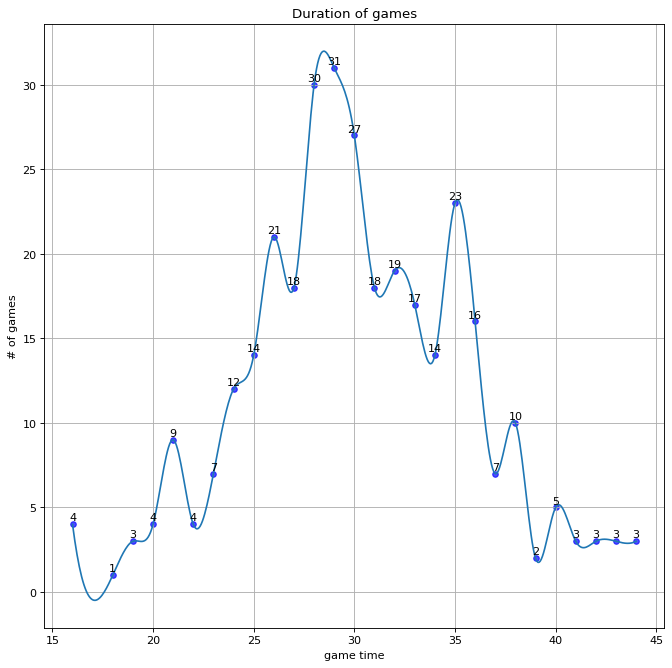

In [36]:
## 그래프 plot

fig, ax = plt.subplots(figsize=(10, 10), dpi= 80)

x = gameDuration_df.index
y = gameDuration_df.values

ax.scatter(x=gameDuration_df.index, y=gameDuration_df.values, s=25, color='blue', alpha=0.7)
X_Y_Spline = make_interp_spline(x,y)
X = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X)


plt.xlabel('game time')
plt.ylabel('# of games')
plt.title('Duration of games')
plt.grid(True)


plt.plot(X, Y_)

# Annotate
for index, value in gameDuration_df.iteritems():
  ax.text(index, value+.7, s=round(value, 2), horizontalalignment= 'center', verticalalignment='top', fontsize=10)

plt.show()